In [35]:
#downloading data.
#!echo $(pwd)
#!wget -P ./data/raw "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip"
#!unzip -q ./data/raw/flickr8k.zip -d ./data/raw/flickr8k
#!rm ./data/raw/flickr8k.zip
#!echo "Downloaded Flickr8k dataset successfully."
#data/raw/flickr8k/captions.txt
raw_data_path = './data/raw/flickr8k'

In [ ]:
import nltk

#nltk.download('punkt')
#nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import decode_image

import pandas as pd
from PIL import Image

import os

In [36]:
df = pd.read_csv(raw_data_path+'/captions.txt',sep=',',header=None,skiprows=1,names=['image', 'caption'])
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    cleaned = []
    for tok in tokens:
        if tok in stop_words:
            continue
        cleaned.append(stemmer.stem(tok))
    return ' '.join(cleaned)

# Exemplo de uso:
if __name__ == "__main__":
    examples = [
        "This is a sample sentence, to test removal of stopwords and stemming.",
        "Another example: NLTK-based preprocessing!"
    ]
    for s in examples:
        print(clean_text(s))


sampl sentenc test remov stopword stem
anoth exampl nltk base preprocess


In [5]:
df['cleaned'] = df['caption'].apply(clean_text)
df.head()

,image,caption,cleaned
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,child pink dress climb set stair entri way
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,girl go wooden build
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,littl girl climb wooden playhous
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,littl girl climb stair playhous
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,littl girl pink dress go wooden cabin


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['cleaned'].to_list())
names = vectorizer.get_feature_names_out()
names

array(['08', '10', '104', ..., 'zone', 'zoo', 'zoom'], dtype=object)

In [7]:
import numpy as np
somado = np.sum(X.toarray(),axis=0)
idxs = np.argsort(somado)[::-1]
print(names[idxs])
nomes = {names[idx]:somado[idx] for idx in idxs}

for i,(k,v) in enumerate(nomes.items()):
  print(f"{k:10}{v:5}")
  if i>30:
    break

['dog' 'man' 'two' ... 'loav' 'loader' '08']
dog       10263
man        7284
two        5643
boy        4247
girl       4172
white      3960
black      3848
woman      3402
run        3367
play       3340
wear       3226
stand      3175
jump       2891
peopl      2885
water      2825
red        2692
young      2630
brown      2578
sit        2305
blue       2282
shirt      2099
walk       2040
hold       1883
ball       1849
littl      1768
grass      1626
ride       1620
snow       1558
person     1546
child      1546
look       1520
three      1387


In [8]:
classes = ['dog','man','woman','child','water','ball','car','snow']
class2label = {classes[i]:i for i in range(len(classes))}
label2class = {i:classes[i] for i in range(len(classes))}

df['in_class'] = df['cleaned'].apply(lambda x: any([word in classes for word in x.split()]))
df_filtered = df[df['in_class']]
df_filtered['label'] = df_filtered['cleaned'].apply(lambda x: [class2label[word] for word in x.split() if word in classes][0])
df_filtered.head(25)

/tmp/ipykernel_70385/1061128178.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = df_filtered['cleaned'].apply(lambda x: [class2label[word] for word in x.split() if word in classes][0])


,image,caption,cleaned,in_class,label
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,child pink dress climb set stair entri way,True,3
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,black dog spot dog fight,True,0
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...,black dog tri color dog play road,True,0
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...,black dog white dog brown spot stare street,True,0
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...,two dog differ breed look road,True,0
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .,two dog pavement move toward,True,0
15,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .,man lay bench dog sit,True,1
16,1003163366_44323f5815.jpg,A man lays on the bench to which a white dog i...,man lay bench white dog also tie,True,1
17,1003163366_44323f5815.jpg,a man sleeping on a bench outside with a white...,man sleep bench outsid white black dog sit next,True,1
18,1003163366_44323f5815.jpg,A shirtless man lies on a park bench with his ...,shirtless man lie park bench dog,True,1


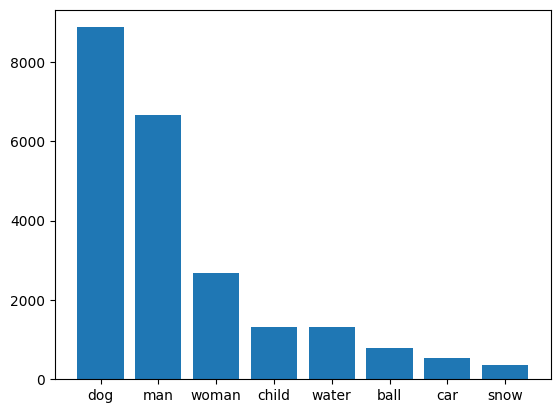

In [9]:
import matplotlib.pyplot as plt
classes_counts = np.array(df_filtered['label'].value_counts().to_list())
plt.bar(np.arange(len(classes)),classes_counts)
plt.xticks(np.arange(len(classes)),classes)
plt.show()

In [110]:
n_samples = 1000
samples_per_class = int(n_samples/df_filtered['label'].nunique())
samples_indexes = set()
for label in df_filtered['label'].unique():
  indexes = np.array(df_filtered[df_filtered['label']==label].sample(samples_per_class).index)
  samples_indexes = samples_indexes.union(set(indexes))

samples_indexes = list(samples_indexes)
df_samples = df_filtered.loc[samples_indexes]
df_samples.head()

,image,caption,cleaned,in_class,label
38912,590445887_4d4fa43923.jpg,A woman with green hair hula hoops before a cr...,woman green hair hula hoop crowd,True,2
14337,2759089516_cbb993cb92.jpg,A child wearing gray shorts and pink-bottomed ...,child wear gray short pink bottom sneaker craw...,True,3
36865,463978865_c87c6ca84c.jpg,A man sitting on the left near a man walking a...,man sit left near man walk along side street c...,True,1
20483,3116731299_6139b25c18.jpg,A small dog is carrying a stick in his mouth .,small dog carri stick mouth,True,0
22529,3210359094_ee51285301.jpg,A young girl is sitting in the snow with a pin...,young girl sit snow pink fur hood head,True,7


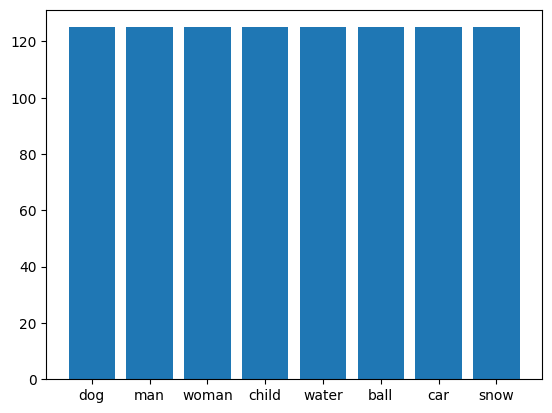

In [18]:
import matplotlib.pyplot as plt
classes_counts = np.array(df_samples['label'].value_counts().to_list())
plt.bar(np.arange(len(classes)),classes_counts)
plt.xticks(np.arange(len(classes)),classes)
plt.show()

In [12]:
df_samples.columns

Index(['image', 'caption', 'cleaned', 'in_class', 'label'], dtype='object')

In [ ]:
df_samples.index

Index([22529, 14338, 18436, 30724, 28684, 10253, 26640, 32790, 22551, 26652,
       ...
       38893, 24559, 30707,  6132,  4083, 24565, 16375,  2041, 22526, 22527],
      dtype='int64', length=1000)

In [108]:
type(df_samples.iloc[0]['label'])

numpy.int64

In [111]:
df_samples = df_samples.reset_index()
df_samples = df_samples[['image', 'caption', 'label']]
#df_samples['label'] = df_samples['label'].astype(float) 
df_samples

,image,caption,label
0,590445887_4d4fa43923.jpg,A woman with green hair hula hoops before a cr...,2
1,2759089516_cbb993cb92.jpg,A child wearing gray shorts and pink-bottomed ...,3
2,463978865_c87c6ca84c.jpg,A man sitting on the left near a man walking a...,1
3,3116731299_6139b25c18.jpg,A small dog is carrying a stick in his mouth .,0
4,3210359094_ee51285301.jpg,A young girl is sitting in the snow with a pin...,7
...,...,...,...
995,2622971954_59f192922d.jpg,A man raises his hands from within a crowd of ...,1
996,2623146491_b64698b875.jpg,A man is standing in the checkout line at a st...,1
997,3009383694_e045c6169e.jpg,A view from below of a man bungee jumping,1
998,3210359094_ee51285301.jpg,A little girl sitting in the snow,7


In [133]:
class ImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, label_map=None,
                 file_column='file',label_column='label',caption_column='caption'):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = label_map
        self.file_column=file_column
        self.label_column=label_column
        self.caption_column=caption_column

        if file_column not in df.columns or label_column not in df.columns:
            raise ValueError("Precisa das colunas de label e nome do arquivo")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.df.iloc[idx]
        img_name = row[self.file_column]
        label = row[self.label_column]
        caption = row[self.caption_column]

        ## Abre a imagem
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Converte label se necessário
        if self.label_map is not None:
            label = self.label_map[label]
        else:
            label = int(label)

        # Aplica transform se houver
        if self.transform:
            image = self.transform(image)

        return image, label, caption


image_dim = (224,224) ## bota as imagens para uma dimensão só
transform = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.ToTensor(),
])

flickr8k_cleaned = ImageDataset(df_samples, raw_data_path+'/Images', file_column='image',transform=transform)

In [134]:
print(f"image data: {flickr8k_cleaned[0][0][0]}")
print(f"label: {flickr8k_cleaned[0][1]}")
print(f"caption: {flickr8k_cleaned[0][2]}")

image data: tensor([[0.2275, 0.2353, 0.2392,  ..., 0.0706, 0.0745, 0.0745],
        [0.2196, 0.2275, 0.2275,  ..., 0.0706, 0.0745, 0.0784],
        [0.2039, 0.2118, 0.2157,  ..., 0.0706, 0.0784, 0.0824],
        ...,
        [0.3098, 0.3176, 0.3216,  ..., 0.0549, 0.0392, 0.0157],
        [0.2588, 0.2667, 0.2706,  ..., 0.0588, 0.0392, 0.0157],
        [0.2118, 0.2118, 0.2078,  ..., 0.0627, 0.0431, 0.0118]])
label: 2
caption: A woman with green hair hula hoops before a crowd .


In [135]:
train, test = torch.utils.data.random_split(flickr8k_cleaned, [0.8, 0.2])
save_dir = './data/processed'
torch.save(flickr8k_cleaned, save_dir+'/mini_flickr8k.pt')
torch.save(train, save_dir+'/train_subset.pt')
torch.save(test, save_dir+'/test_subset.pt')


In [ ]:
data = torch.load(save_dir+'/mini_flickr8k.pt', weights_only=False)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.75, 0.125, 0.125])
train_dataset[0]

(tensor([[[0.3922, 0.4157, 0.3882,  ..., 0.4784, 0.4745, 0.4745],
          [0.3882, 0.4235, 0.3843,  ..., 0.4784, 0.4824, 0.4863],
          [0.3765, 0.4000, 0.3922,  ..., 0.4745, 0.4824, 0.4863],
          ...,
          [0.2863, 0.2941, 0.2980,  ..., 0.5294, 0.5373, 0.5333],
          [0.3137, 0.3098, 0.3059,  ..., 0.5216, 0.5255, 0.5176],
          [0.5176, 0.5059, 0.5059,  ..., 0.5333, 0.5255, 0.5294]],
 
         [[0.5373, 0.5647, 0.5294,  ..., 0.6039, 0.6039, 0.6157],
          [0.5294, 0.5647, 0.5333,  ..., 0.6078, 0.6039, 0.6157],
          [0.5294, 0.5529, 0.5529,  ..., 0.6078, 0.6078, 0.6196],
          ...,
          [0.3176, 0.3176, 0.3137,  ..., 0.5333, 0.5412, 0.5373],
          [0.3412, 0.3412, 0.3451,  ..., 0.5255, 0.5294, 0.5216],
          [0.5647, 0.5569, 0.5529,  ..., 0.5373, 0.5294, 0.5333]],
 
         [[0.4431, 0.4667, 0.4392,  ..., 0.7490, 0.7490, 0.7490],
          [0.4392, 0.4706, 0.4353,  ..., 0.7451, 0.7490, 0.7412],
          [0.4235, 0.4510, 0.4471,  ...,

In [ ]:
## Fazendo os loaders
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader   = DataLoader(test_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)